# Preprocessing & Training

### Goal:
<p>Create a cleaned development dataset you can use to complete the modeling step of your project.</p>

### Steps:
<ul><li>Create dummy or indicator features for categorical variables</li><li>Standardize the magnitude of numeric features using a scaler</li><li>Split into testing and training datasets</li></ul>
Review the following questions and apply them to your dataset:<ul><li>Does my data set have any categorical data, such as Gender or day of the week?</li><li>Do my features have data values that range from 0 - 100 or 0-1 or both and more?  </li></ul>

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from library.sb_utils import save_file

In [2]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
adopted = pd.read_csv('data/cats_trimmed.csv')
adopted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489 entries, 0 to 6488
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    6489 non-null   object 
 1   gender                 6489 non-null   object 
 2   size                   6489 non-null   object 
 3   coat                   6489 non-null   object 
 4   distance               6489 non-null   float64
 5   spayed_neutered        6489 non-null   bool   
 6   house_trained          6489 non-null   bool   
 7   declawed               6489 non-null   bool   
 8   special_needs          6489 non-null   bool   
 9   shots_current          6489 non-null   bool   
 10  breed_primary          6489 non-null   object 
 11  breed_secondary        6489 non-null   object 
 12  breed_mixed            6489 non-null   bool   
 13  breed_unknown          6489 non-null   bool   
 14  color_primary          6489 non-null   object 
 15  colo

## Dummies!
### After converting bools to ints, of course

In [4]:
df = adopted[['gender', 'size', 'coat', 'duration_as_adoptable', 'hasimage', 'hasvideo', 'spayed_neutered', 'house_trained', 'declawed', 'special_needs', 'shots_current', 'goodwith_children', 'goodwith_dogs', 'goodwith_cats']]
df.loc[:, ['hasimage', 'hasvideo', 'spayed_neutered', 'house_trained', 'declawed', 'special_needs', 'shots_current']] = adopted.loc[:, ['hasimage', 'hasvideo', 'spayed_neutered', 'house_trained', 'declawed', 'special_needs', 'shots_current']].astype('int64')
df = pd.get_dummies(df)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
# drop one of each of the dummy category columns so those features don't double-weight anything
df.drop(['size_Extra Large', 'gender_Female', 'coat_Hairless', 'goodwith_children_False', 'goodwith_dogs_False', 'goodwith_cats_False'], axis=1, inplace=True)

## Imputing Values

In [6]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed = imp.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)

## Scaling using StandardScaler()

In [7]:
X = df.drop(columns='duration_as_adoptable')
y = df.duration_as_adoptable

scaler = StandardScaler()
scaled = scaler.fit_transform(X)

In [8]:
scaled_X = pd.DataFrame(scaled, columns=X.columns)
scaled_X.describe()

,hasimage,hasvideo,spayed_neutered,house_trained,declawed,special_needs,shots_current,gender_Male,size_Large,size_Medium,size_Small,coat_Long,coat_Medium,coat_Short,coat_unknown,goodwith_children_True,goodwith_children_unknown,goodwith_dogs_True,goodwith_dogs_unknown,goodwith_cats_True,goodwith_cats_unknown
count,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000,6489.00000
mean,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000
std,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008,1.00008
min,-5.38903,-0.19213,-2.86887,-1.26894,-0.09497,-0.13900,-4.48741,-0.95730,-0.29454,-1.90570,-0.38825,-0.30067,-0.37793,-1.76561,-0.18909,-0.60340,-1.36886,-0.49136,-1.71113,-0.98213,-0.92987
25%,0.18556,-0.19213,0.34857,-1.26894,-0.09497,-0.13900,0.22285,-0.95730,-0.29454,0.52474,-0.38825,-0.30067,-0.37793,0.56638,-0.18909,-0.60340,-1.36886,-0.49136,-1.71113,-0.98213,-0.92987
50%,0.18556,-0.19213,0.34857,0.78806,-0.09497,-0.13900,0.22285,-0.95730,-0.29454,0.52474,-0.38825,-0.30067,-0.37793,0.56638,-0.18909,-0.60340,0.73053,-0.49136,0.58441,-0.98213,-0.92987
75%,0.18556,-0.19213,0.34857,0.78806,-0.09497,-0.13900,0.22285,1.04461,-0.29454,0.52474,-0.38825,-0.30067,-0.37793,0.56638,-0.18909,1.65727,0.73053,-0.49136,0.58441,1.01820,1.07542
max,0.18556,5.20489,0.34857,0.78806,10.52992,7.19417,0.22285,1.04461,3.39515,0.52474,2.57568,3.32586,2.64598,0.56638,5.28855,1.65727,0.73053,2.03515,0.58441,1.01820,1.07542


## Split into training and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=192)

In [10]:
X_train.shape, X_test.shape

((4542, 21), (1947, 21))

In [11]:
y_train.shape, y_test.shape

((4542,), (1947,))

In [12]:
# save training and test sets
datapath = 'data/tt_sets'
save_file(X_train, 'cats_X_train.csv', datapath)
save_file(X_test, 'cats_X_test.csv', datapath)
save_file(y_train, 'cats_y_train.csv', datapath)
save_file(y_test, 'cats_y_test.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/cats_X_train.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/cats_X_test.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/cats_y_train.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/cats_y_test.csv"


# Model Selection
### Goal: Build two to three different models and identify the best one.
<ul><li>Fit your models with a training dataset</li>
<li>Review model outcomes — Iterate over additional models as needed</li>
<li>Identify the final model that you think is the best model for this project</li></ul>
 Review the following questions and apply them to your analysis: 
<ul><li>Does my data involve a time series or forecasting? If so, am I splitting the train and test data appropriately?</li>
<li>Is my response variable continuous or categorical?</li></ul>

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

### RandomForestRegressor

In [14]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.28026128475320655

In [15]:
rf_cv = cross_validate(rf, X_train, y_train, cv=5)
rf_cv_scores_preopt = rf_cv['test_score']
rf_cv_scores_preopt

array([-0.05144808, -0.0644872 , -0.02181257, -0.07141083, -0.02124485])

In [16]:
np.mean(rf_cv_scores_preopt), np.std(rf_cv_scores_preopt)

(-0.04608070699790749, 0.021047493873755284)

In [17]:
rf_pred = rf.predict(X_test)
rmse_rf_preopt = np.sqrt(mean_squared_error(y_test, rf_pred))
print("RMSE : % f" %(rmse_rf_preopt))

RMSE :  36.360676


In [18]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rf_grid_params = {
        'n_estimators': n_est,
        'max_depth': [1, 2, 3,4,5, 6,7,8,9, 10, None]
}

In [19]:
from sklearn.model_selection import GridSearchCV

gcv = GridSearchCV(rf, param_grid=rf_grid_params, cv=5, n_jobs=-1)
gcv.fit(X_train, y_train)
gcv_params = gcv.best_params_

gcv_params

{'max_depth': 5, 'n_estimators': 54}

In [20]:
rf = RandomForestRegressor(n_estimators=gcv_params['n_estimators'], max_depth=gcv_params['max_depth'])
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.09308043338667638

In [21]:
rf_cv_train = cross_validate(rf, X_train, y_train, cv=5)
rf_cv_test = cross_validate(rf, X_test, y_test, cv=5)
rf_cv_train['test_score'], rf_cv_test['test_score']

(array([0.02673107, 0.05032619, 0.02826698, 0.02279189, 0.06500882]),
 array([ 0.07198972,  0.00806437, -0.00104044,  0.04676484,  0.02932329]))

In [22]:
rf_train_score = np.mean(rf_cv_train['test_score'])
rf_test_score = np.mean(rf_cv_test['test_score'])

print("Average CV Score, Training Set:", rf_train_score)
print("Average CV Score, Trest Set:", rf_test_score)

Average CV Score, Training Set: 0.03862498955846623
Average CV Score, Trest Set: 0.031020356734935573


In [23]:
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_test_pred))
print("RMSE Training Set : % f" %(rf_rmse_train))
print("RMSE Test Set : % f" %(rf_rmse_test))

RMSE Training Set :  34.348187
RMSE Test Set :  34.790647


### GradientBoostingRegressor

In [24]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb.score(X_train, y_train)

0.10238353196836003

In [25]:
gb_cv = cross_validate(gb, X_train, y_train, cv=5)
gb_cv_scores_preopt = gb_cv['test_score']
gb_cv_scores_preopt

array([0.03209128, 0.0372315 , 0.00130893, 0.01913395, 0.07248218])

In [26]:
np.mean(gb_cv_scores_preopt), np.std(gb_cv_scores_preopt)

(0.03244956971478576, 0.023548460320636126)

In [27]:
gb_pred = gb.predict(X_test)
rmse_gb_preopt = np.sqrt(mean_squared_error(y_test, gb_pred))
print("RMSE : % f" %(rmse_gb_preopt))

RMSE :  34.836562


In [28]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
gb_grid_params = {
        'learning_rate': [.01, .1, 1],
        'n_estimators': n_est,
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

In [29]:
gb_grid_cv = GridSearchCV(gb, param_grid=gb_grid_params, cv=5, n_jobs=-1)
gb_grid_cv

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000]})

In [30]:
gb_grid_cv.fit(X_train, y_train)
gb_grid_cv_params = gb_grid_cv.best_params_

gb_grid_cv_params

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 233}

In [31]:
gb = GradientBoostingRegressor(n_estimators=gb_grid_cv_params['n_estimators'], max_depth=gb_grid_cv_params['max_depth'], learning_rate=gb_grid_cv_params['learning_rate'])
gb.fit(X_train, y_train)
gb.score(X_train, y_train)

0.11998736211015593

In [32]:
gb_cv_train = cross_validate(gb, X_train, y_train, cv=5)
gb_cv_test = cross_validate(gb, X_test, y_test, cv=5)
gb_cv_train['test_score'], gb_cv_test['test_score']

(array([0.03437984, 0.05307066, 0.03203477, 0.02611835, 0.07216558]),
 array([ 0.0459869 ,  0.00438719, -0.02320723, -0.00915839,  0.02800777]))

In [33]:
gb_train_score = np.mean(gb_cv_train['test_score'])
gb_test_score = np.mean(gb_cv_test['test_score'])

print("Average CV Score, Training Set:", gb_train_score)
print("Average CV Score, Trest Set:", gb_test_score)

Average CV Score, Training Set: 0.04355384088493548
Average CV Score, Trest Set: 0.00920324824704466


In [34]:
gb_train_pred = gb.predict(X_train)
gb_test_pred = gb.predict(X_test)
gb_rmse_train = np.sqrt(mean_squared_error(y_train, gb_train_pred))
gb_rmse_test = np.sqrt(mean_squared_error(y_test, gb_test_pred))
print("RMSE Training Set : % f" %(gb_rmse_train))
print("RMSE Test Set : % f" %(gb_rmse_test))

RMSE Training Set :  33.834821
RMSE Test Set :  34.815294


### KNeighborsRegressor

In [35]:
kn = KNeighborsRegressor(n_neighbors=25, weights='distance')
kn.fit(X_train, y_train)
kn.score(X_train, y_train)

0.2894233765528853

In [36]:
kn_cv = cross_validate(kn, X_train, y_train, cv=5)
kn_cv_scores_preopt = kn_cv['test_score']
np.mean(kn_cv_scores_preopt), np.std(kn_cv_scores_preopt)

(-0.07995864867532512, 0.02796840303593159)

In [37]:
kn_pred = kn.predict(X_test)
rmse_kn_preopt = np.sqrt(mean_squared_error(y_test, kn_pred))
print("RMSE : % f" %(rmse_kn_preopt))

RMSE :  36.830399


In [38]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
kn_grid_params = {
        'weights': ['uniform', 'distance'],
        'n_neighbors': n_est,
        'p': [1, 2]
}

In [39]:
kn_grid_cv = GridSearchCV(kn, param_grid=kn_grid_params, cv=5, n_jobs=-1)
kn_grid_cv.fit(X_train, y_train)
kn_grid_cv_params = kn_grid_cv.best_params_

kn_grid_cv_params

{'n_neighbors': 88, 'p': 2, 'weights': 'uniform'}

In [40]:
kn = KNeighborsRegressor(n_neighbors=kn_grid_cv_params['n_neighbors'], weights=kn_grid_cv_params['weights'], p=kn_grid_cv_params['p'])
kn.fit(X_train, y_train)
kn.score(X_train, y_train)

0.05030333695068101

In [41]:
kn_cv_train = cross_validate(kn, X_train, y_train, cv=5)
kn_cv_test = cross_validate(kn, X_test, y_test, cv=5)
kn_cv_train['test_score'], kn_cv_test['test_score']

(array([0.00547563, 0.03781735, 0.02129488, 0.03582559, 0.05169464]),
 array([0.04565515, 0.0043644 , 0.01084321, 0.00673208, 0.03264615]))

In [42]:
kn_train_score = np.mean(kn_cv_train['test_score'])
kn_test_score = np.mean(kn_cv_test['test_score'])

print("Average CV Score, Training Set:", kn_train_score)
print("Average CV Score, Trest Set:", kn_test_score)

Average CV Score, Training Set: 0.030421620622292277
Average CV Score, Trest Set: 0.020048197767960095


In [43]:
kn_train_pred = kn.predict(X_train)
kn_test_pred = kn.predict(X_test)
kn_rmse_train = np.sqrt(mean_squared_error(y_train, kn_train_pred))
kn_rmse_test = np.sqrt(mean_squared_error(y_test, kn_test_pred))
print("RMSE Training Set : % f" %(kn_rmse_train))
print("RMSE Test Set : % f" %(kn_rmse_test))

RMSE Training Set :  35.148912
RMSE Test Set :  34.753891


### XGBoost

In [44]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 50)
xg.fit(X_train, y_train)
xg.score(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.2525775779590945

In [45]:
xg_cv = cross_validate(xg, X_train, y_train, cv=5)
xg_cv_scores_preopt = xg_cv['test_score']
np.mean(xg_cv_scores_preopt), np.std(xg_cv_scores_preopt)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndar

(-0.04350624730979828, 0.030084781690216614)

In [60]:
xg_pred = xg.predict(X_test)
rmse_xg_preopt = np.sqrt(mean_squared_error(y_test, xg_pred))
print("RMSE : % f" %(rmse_xg_preopt))

RMSE :  35.158195


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [47]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
xg_grid_params = {
        'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:logistic'],
        'n_estimators': n_est,
}

In [48]:
xg_grid_cv = GridSearchCV(xg, param_grid=xg_grid_params, cv=5, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
xg_grid_cv_params = xg_grid_cv.best_params_

xg_grid_cv_params

{'n_estimators': 10, 'objective': 'reg:squarederror'}

In [49]:
xg = xgb.XGBRegressor(objective=xg_grid_cv_params['objective'], n_estimators = xg_grid_cv_params['n_estimators'])
xg.fit(X_train, y_train)
xg.score(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.1509886910239735

In [50]:
xg_cv_train = cross_validate(xg, X_train, y_train, cv=5)
xg_cv_test = cross_validate(xg, X_test, y_test, cv=5)
xg_cv_train['test_score'], xg_cv_test['test_score']

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndar

(array([0.01860874, 0.05055305, 0.01741397, 0.0121177 , 0.06417835]),
 array([ 0.03220687, -0.03327326,  0.01218755, -0.01277528,  0.03203198]))

In [51]:
xg_train_score = np.mean(xg_cv_train['test_score'])
xg_test_score = np.mean(xg_cv_test['test_score'])

print("Average CV Score, Training Set:", xg_train_score)
print("Average CV Score, Trest Set:", xg_test_score)

Average CV Score, Training Set: 0.03257436153717519
Average CV Score, Trest Set: 0.0060755714672682485


In [52]:
xg_train_pred = xg.predict(X_train)
xg_test_pred = xg.predict(X_test)
xg_rmse_train = np.sqrt(mean_squared_error(y_train, xg_train_pred))
xg_rmse_test = np.sqrt(mean_squared_error(y_test, xg_test_pred))
print("RMSE Training Set : % f" %(xg_rmse_train))
print("RMSE Test Set : % f" %(xg_rmse_test))

RMSE Training Set :  33.233507
RMSE Test Set :  35.158195


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Model Comparisons

In [53]:
model_scores = pd.DataFrame({'CV Train': [np.mean(rf_train_score), np.mean(gb_train_score), np.mean(kn_train_score), np.mean(xg_train_score)], 'RMSE Train': [rf_rmse_train, gb_rmse_train, kn_rmse_train, xg_rmse_train],'CV Test': [np.mean(rf_test_score), np.mean(gb_test_score), np.mean(kn_test_score), np.mean(xg_test_score)], 'RMSE Test': [rf_rmse_test, gb_rmse_test, kn_rmse_test, xg_rmse_test]}, index=['RandomForest', 'GradientBoosting', 'KNNeighbors', 'XGBoost'])
model_scores

,CV Train,RMSE Train,CV Test,RMSE Test
RandomForest,0.03862,34.34819,0.03102,34.79065
GradientBoosting,0.04355,33.83482,0.00920,34.81529
KNNeighbors,0.03042,35.14891,0.02005,34.75389
XGBoost,0.03257,33.23351,0.00608,35.15820


In [54]:
print("Model with best CV Score: \nTrain:", model_scores['CV Train'].idxmin(), "\nTest:", model_scores['CV Test'].idxmin())
print("\nModel with best RMSE: \nTrain:", model_scores['RMSE Train'].idxmin(), "\nTest:", model_scores['RMSE Test'].idxmin())

Model with best CV Score: 
Train: KNNeighbors 
Test: XGBoost

Model with best RMSE: 
Train: XGBoost 
Test: KNNeighbors


In [55]:
models = ['RandomForest', 'GradientBoosting', 'KNNeighbors', 'XGBoost','RandomForest', 'GradientBoosting', 'KNNeighbors', 'XGBoost']
cv_scores_all = [np.mean(rf_train_score), np.mean(gb_train_score), np.mean(kn_train_score), np.mean(xg_train_score), np.mean(rf_test_score), np.mean(gb_test_score), np.mean(kn_test_score), np.mean(xg_test_score)]
types = ['train', 'train', 'train', 'train', 'test', 'test', 'test', 'test']
rmse_scores_all = [rf_rmse_train, gb_rmse_train, kn_rmse_train, xg_rmse_train, rf_rmse_test, gb_rmse_test, kn_rmse_test, xg_rmse_test]

cv_scores = pd.DataFrame(list(zip(models, cv_scores_all, types)), 
               columns =['Model', 'Scores', 'Type' ]) 
rmse_scores = pd.DataFrame(list(zip(models, rmse_scores_all, types)), 
               columns =['Model', 'Scores', 'Type' ]) 

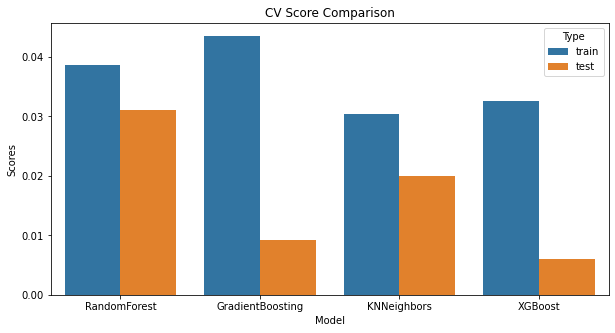

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.subplots(figsize=(10, 5))
sns.barplot(x='Model', y='Scores', hue='Type', data=cv_scores)
plt.title("CV Score Comparison")
plt.show()

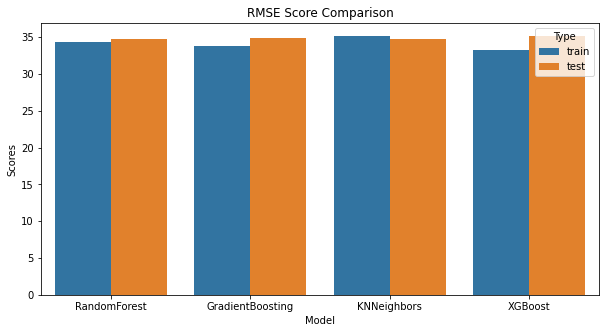

In [57]:
fig=plt.subplots(figsize=(10, 5))
sns.barplot(x='Model', y='Scores', hue='Type', data=rmse_scores)
plt.title("RMSE Score Comparison")
plt.show()

## Conclusion

I'm going to go forward with **KNN** for the cats data. I'm choosing this model because it has the best RMSE score for the test set.

In [63]:
std_test = np.std(y_test)
std_test

35.490261099806496

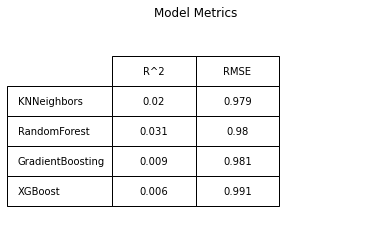

In [67]:
model_scores_test = model_scores.drop(columns=['CV Train','RMSE Train']).rename(columns={'CV Test':'R^2', 'RMSE Test':'RMSE'})

#standardize the RMSE by dividing it by the standard deviation of y_test
model_scores_test['RMSE'] = model_scores_test['RMSE']/std_test

#sort scores by lowest RMSE
model_scores_test.sort_values(by='RMSE', inplace=True)

fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')

table = ax.table(
    cellText=np.round(model_scores_test.values,3), 
    colLabels=model_scores_test.columns, 
    rowLabels=model_scores_test.index, 
    loc='center', 
    cellLoc='center'
)

table.scale(.5, 2.5)

plt.title('Model Metrics')

plt.show()

fig.savefig('assets/cats_model_metrics.png', bbox_inches="tight")
